In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
from tqdm import tqdm

# Introduction

In this notebook, I do some analysis - mostly brief, exploratory analysis - of my liked songs on Spotify. This project is purely driven by personal interest, with no pretensions of practical use. I like music as much as the next person, so when I learned that Spotify attempted to quantify various characteristics of music and automatically detect others, I became interested in what I could learn about my own taste, other than I like songs that are mostly metal, some mixture between corny and aggressive, and loud.

In [3]:
df = pd.read_csv('liked_songs.csv', index_col=0)
print(f'There are {len(df)} rows in the dataframe.')
df.head()

There are 1336 rows in the dataframe.


,id,track_name,artist,album_name,album_release_date,album_track_num,album_track_placement,genre,duration_ms,explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2mkIuDdISUvCcrxxZ4EN6b,Edge of the Night,Nite,Voices of the Kronian Moon,2022-03-25,6,0.750000,NaN,5.057467,False,...,9,-5.673,0,0.1450,0.000010,0.777,0.122,0.1700,144.036,4
1,0DDUNKcxiNVf7mMhGovPT0,Kronian Moon,Nite,Voices of the Kronian Moon,2022-03-25,2,0.250000,NaN,3.989900,False,...,2,-4.680,0,0.0578,0.000018,0.516,0.106,0.1670,123.982,4
2,4oTLgIDkeBPB4YjHRGJ6EI,Glitch Cannon,Artificial Brain,Artificial Brain,2022-06-03,2,0.200000,NaN,3.635300,False,...,5,-9.562,0,0.0614,0.000124,0.945,0.436,0.0363,95.020,4
3,2Pvxvrbl8J6YFl5vSJzEDp,Discipline 27,EABS,Discipline of Sun Ra,2020-10-30,4,0.571429,NaN,5.344567,False,...,10,-8.203,0,0.0501,0.043400,0.336,0.278,0.2050,90.492,4
4,0BUxtt8OufQRdqpcu2uaXU,The Lady with the Golden Stockings (The Golden...,EABS,Discipline of Sun Ra,2020-10-30,3,0.428571,NaN,3.306467,False,...,11,-9.357,0,0.0564,0.193000,0.944,0.118,0.1850,117.210,3


# Data Cleaning

## Checking the Genre Feature
According to Spotify's API documentation, when looking up track info, the response should either contain an array of genres for the tracks artist, which should be empty if no genres are assigned. This does not seem to actually be the case at least for every artist, and when running a few google searches, I found people who had similar issues over the past several years. I wrote my code to save genre information to a csv if present and enter a NaN value otherwise. Here, I check to see if there was any genre information. If there is not, I drop the feature.

In [4]:
df['genre'].unique()[0]

nan

In [5]:
if len(df['genre'].unique()) == 1:
    genre_val = df['genre'].unique()[0]
    print(f'The genre field contains only the following value: {genre_val}.')
    df = df.drop('genre', axis=1)
else:
    print('The genre feature contains non-nan values.')

The genre field contains only the following value: nan.


## Encoding Album Release Dates
Spotify does not always have exact release dates. Sometimes it has release years. For consistency and cleanliness, I will keep only release years for all albums. Values are either in YYYY-MM-DD format or are just the years, so to get years, I split on dashes, and keep only the first entry in the resulting list.

In [6]:
df['album_release_date'] = df['album_release_date'].str.split('-').map(lambda x: int(x[0]))

## Renaming Columns
I rename album_release_date to album_release_year because of the above change. Additionally, I rename duration_ms to duration_min, since the units are minutes.

In [7]:
df = df.rename(columns={'album_release_date':'album_release_year', 'duration_ms':'duration_min'})

# Exploratory Data Analysis

In [8]:
numerical = ['album_track_num', 'album_track_placement', 'album_release_year', 'duration_min', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
boolean = ['mode', 'explicit']
categorical = ['artist_name', 'album_name']
song_info = ['track_name', 'artist', 'album_name']
df[numerical].describe()

,album_track_num,album_track_placement,album_release_year,duration_min,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,4.155689,0.433919,2010.854790,6.186966,13.269461,0.337626,0.825712,5.208832,-6.565744,0.085956,0.054443,0.435847,0.223005,0.211099,123.759373,3.815120
std,2.955300,0.278496,7.549776,3.615311,15.025945,0.144844,0.199650,3.588865,3.450206,0.060603,0.173401,0.372322,0.166793,0.166339,29.276529,0.540034
min,1.000000,0.030303,1972.000000,0.968217,0.000000,0.059300,0.000707,0.000000,-42.238000,0.024900,0.000000,0.000000,0.020400,0.021500,56.542000,1.000000
25%,2.000000,0.200000,2008.000000,4.203025,0.000000,0.217000,0.762750,2.000000,-7.747250,0.046100,0.000020,0.012175,0.104000,0.079875,102.066500,4.000000
50%,3.000000,0.375000,2013.000000,5.304775,9.000000,0.336500,0.908000,5.000000,-5.793500,0.068800,0.000220,0.460500,0.156000,0.162000,120.035500,4.000000
75%,6.000000,0.625000,2016.000000,7.189333,23.000000,0.443250,0.961000,8.000000,-4.532750,0.103000,0.005097,0.816250,0.313250,0.300000,143.386000,4.000000
max,16.000000,1.000000,2022.000000,57.003767,73.000000,0.903000,0.999000,11.000000,2.121000,0.798000,0.985000,0.995000,0.970000,0.964000,200.188000,5.000000


In [9]:
for feat in numerical[2:]:
    print(f'________________________{feat.upper()}________________________')
    min_feat_values = df[df[feat] == df[feat].min()][song_info+[feat]].values[0]
    max_feat_values = df[df[feat] == df[feat].max()][song_info+[feat]].values[0]
    print(f'The song with the highest {feat} is {max_feat_values[0]} by {max_feat_values[1]} off of the album {max_feat_values[2]}, with a {feat} value of {max_feat_values[3]}')
    print(f'The song with the lowest {feat} is {min_feat_values[0]} by {min_feat_values[1]} off of the album {min_feat_values[2]}, with a {feat} value of {min_feat_values[3]}\n')

________________________ALBUM_RELEASE_YEAR________________________
The song with the highest album_release_year is Edge of the Night by Nite off of the album Voices of the Kronian Moon, with a album_release_year value of 2022
The song with the lowest album_release_year is Suicide by Dust off of the album Hard Attack/Dust, with a album_release_year value of 1972

________________________DURATION_MIN________________________
The song with the highest duration_min is Monolithe IV by Monolithe off of the album Monolithe IV, with a duration_min value of 57.00376666666667
The song with the lowest duration_min is I Accept Your Last Wish by Gridlink off of the album Orphan, with a duration_min value of 0.9682166666666668

________________________POPULARITY________________________
The song with the highest popularity is C.R.E.A.M. (Cash Rules Everything Around Me) (feat. Method Man, Raekwon, Inspectah Deck & Buddha Monk) by Wu-Tang Clan off of the album Enter The Wu-Tang (36 Chambers) [Expanded 

Most of the above are very sensible, with the exception of a few values that suggest errors on Spotify's end. For brevity, I will only discuss potential errors.

Sepal by Emptyset is purely instrumental, but Spotify is fairly confident it is largely speech. The song seems to largely consist of a recording of a person playing a wind or reed instrument, including the sound of the breath, edited in various ways.

Spotify seems to have struggled with Edeste by Khôrada, finding its modality to be major and its time signature presumably to be 1/4. While my music theory is rusty, the song to be is not so obviously major. Further, Spotify's [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) states they give songs time signature values ranging from 3 to 7, corresponding to 3/4, 4/4, 5/4, 6/4 and 7/4, but they gave this song a 1. It is unclear why this is the case. The song is in 6/8, but there are some drony sections that might confuse a computer trying to assign the song a time signature.

I suspect the time_signature identification might be unreliable. In addition to the above, I know I have a song in my liked songs that is 7/4, Foe by the band Leprous, but I have no songs with time_signature = 7. First, I check what time signature that song was assigned.

In [10]:
df[df['track_name'] == 'Foe'][song_info+['time_signature']]

,track_name,artist,album_name,time_signature
918,Foe,Leprous,Coal,1


Similarly to Edeste, this song has a time_signature value of 1. And the percussion in this [song](https://www.youtube.com/watch?v=D61fSxqBLwc) makes the time signature a bit non-obvious, even to a human listener. This makes me think that maybe time_signature values of 1 are assigned if the time signature is unknown. I peak at the songs with time_signature = 1 to find out more.

In [11]:
time_sig_1 = df[df['time_signature'] == 1]
print(f'There are {len(time_sig_1)} songs with a time_signature value of 1')
time_sig_1[song_info]

There are 23 songs with a time_signature value of 1


,track_name,artist,album_name
5,Edeste,Khôrada,Salt
136,Into the Vaults of Ingurgitating Obscurity,Chthe'ilist,Le Dernier Crépuscule
171,"Shake My Hand, Bow down and Die",Die Choking,III
187,Motions,Sun Of The Sleepless,To the Elements
272,Within the Dead Horizon,Inferi,Revenant
286,Self Portrait In Ultramarine,Ben Frost,All That You Love Will Be Eviscerated
315,Shed,Meshuggah,Catch Thirty Three
321,Clockworks,Meshuggah,The Violent Sleep of Reason
326,Where Mountains Rise,Immortal,Northern Chaos Gods
360,What a Horrible Night to Have a Curse,The Black Dahlia Murder,Nocturnal


Self Portrait in Ultramarine is drony and noisy, with no discernible time signature. March of the Pigs is in multiple time signatures, one of which is 7/8 according to a google search.

# Univariate Distributions

In [12]:
df.describe()

,album_release_year,album_track_num,album_track_placement,duration_min,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,2010.854790,4.155689,0.433919,6.186966,13.269461,0.337626,0.825712,5.208832,-6.565744,0.566617,0.085956,0.054443,0.435847,0.223005,0.211099,123.759373,3.815120
std,7.549776,2.955300,0.278496,3.615311,15.025945,0.144844,0.199650,3.588865,3.450206,0.495728,0.060603,0.173401,0.372322,0.166793,0.166339,29.276529,0.540034
min,1972.000000,1.000000,0.030303,0.968217,0.000000,0.059300,0.000707,0.000000,-42.238000,0.000000,0.024900,0.000000,0.000000,0.020400,0.021500,56.542000,1.000000
25%,2008.000000,2.000000,0.200000,4.203025,0.000000,0.217000,0.762750,2.000000,-7.747250,0.000000,0.046100,0.000020,0.012175,0.104000,0.079875,102.066500,4.000000
50%,2013.000000,3.000000,0.375000,5.304775,9.000000,0.336500,0.908000,5.000000,-5.793500,1.000000,0.068800,0.000220,0.460500,0.156000,0.162000,120.035500,4.000000
75%,2016.000000,6.000000,0.625000,7.189333,23.000000,0.443250,0.961000,8.000000,-4.532750,1.000000,0.103000,0.005097,0.816250,0.313250,0.300000,143.386000,4.000000
max,2022.000000,16.000000,1.000000,57.003767,73.000000,0.903000,0.999000,11.000000,2.121000,1.000000,0.798000,0.985000,0.995000,0.970000,0.964000,200.188000,5.000000


## Numerical Features

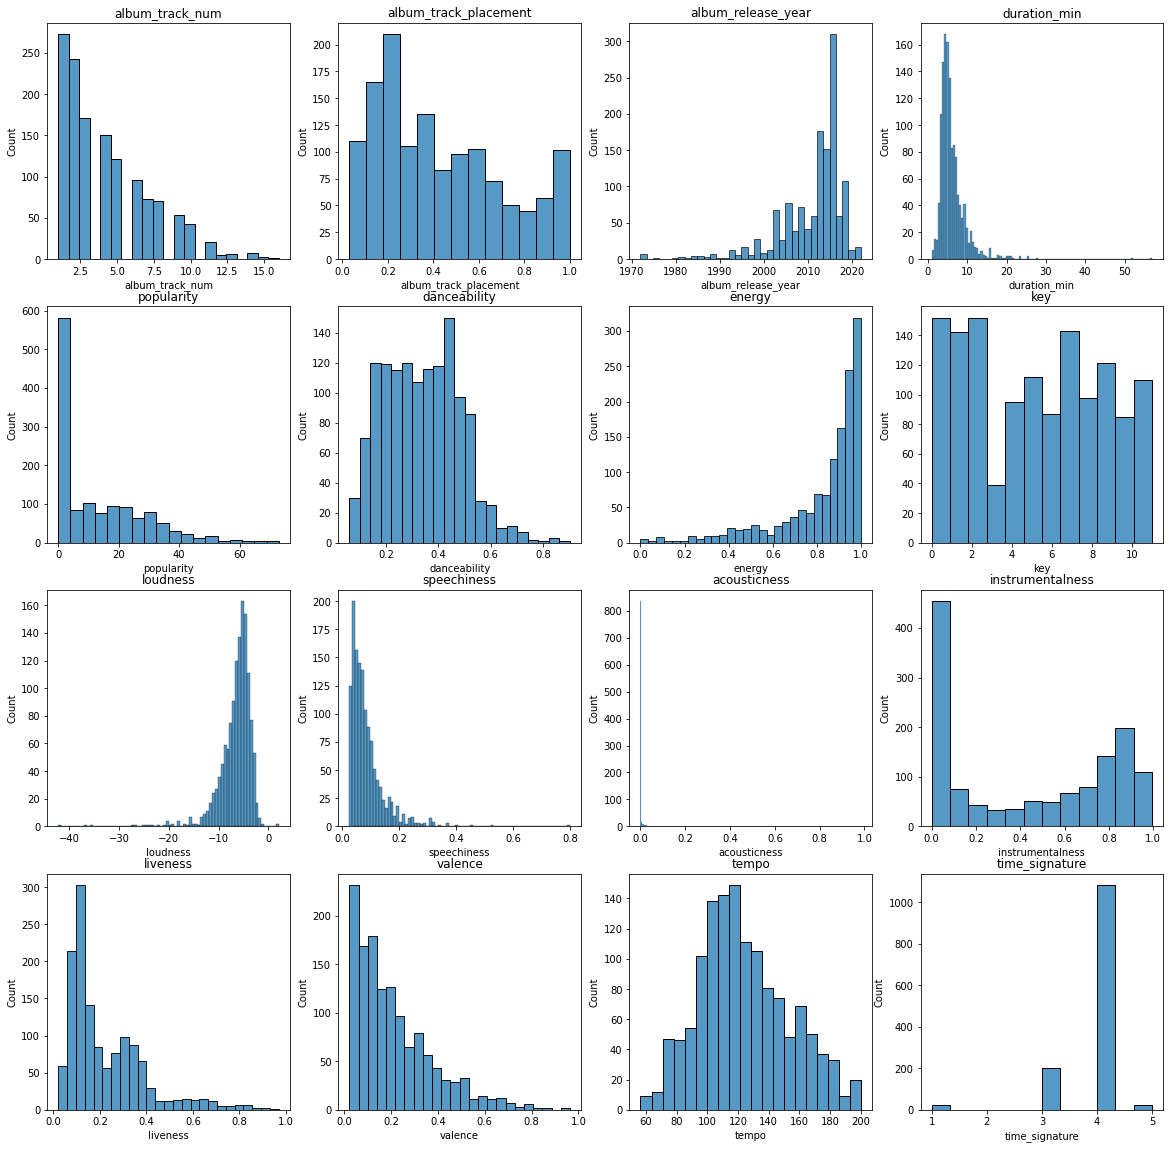

In [13]:
fig, axes = plt.subplots(4,4, figsize=(20,20))

for col, ax in zip(numerical, np.ravel(axes)):
    sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(col)

## Boolean Features

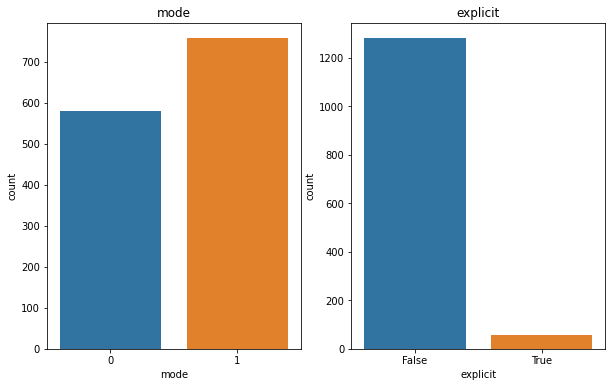

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

for col, ax in zip(boolean, axes):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col)

I am skeptical of both of these. The mode feature represents whether songs are major (1) or minor (0). The plot above suggests most of the songs I've liked have been major. While not impossible, I listen to a lot of metal, which makes the plot unlikely. The second plot is likely misleading. Spotify uses the False value in its explicit feature for songs if it does not know whether lyrics are explicit. Again, I listen to a good bit of metal, so it's highly likely that I've liked a lot songs with unpublished lyrics.

## Other Categorical Features

In [15]:
num_unique_bands = len(df['artist'].unique())
num_unique_albums = len(df['album_name'].unique())
print(f'There are {num_unique_albums} albums by {num_unique_bands} bands.')

There are 666 albums by 434 bands.


In [16]:
print('Top 5 most liked artists:')
df['artist'].value_counts().head(5)

Top 5 most liked artists:


Agent Fresco           23
Sonata Arctica         22
Mors Principium Est    21
Meshuggah              18
GALNERYUS              16
Name: artist, dtype: int64

In [17]:
print('Top 5 most liked albums:')
df['album_name'].value_counts().head(5)

Top 5 most liked albums:


Pariah's Child           14
Songs For The Deaf       14
Destrier                 14
The Tides of Damocles    10
Dawn of the 5TH Era       9
Name: album_name, dtype: int64

I list only the top five for each since something immediately popped out at me - the bands with songs I like most frequently and albums with songs I like most frequently are not comprised mostly of bands or albums I remember liking much, or sometimes at all. On closer inspection, what seems to have happened is that I liked entire albums, which I know is something I've done so I don't forget to get around to listening to an album. This makes it look like I like all of the tracks on the album and inflates the number of songs by the band that I've liked. Combine this with the relatively large number of unique artists and bands, and I do not think there is much useful information in these features.

Since I can confidently state I listen to mostly metal, I would hazard a guess that I listen to bands mostly from a fairly small subset of European countries. If I continue this project in the future, I may find the country of origin for bands to be a more useful feature.

# Bivariate Analysis

<AxesSubplot:>

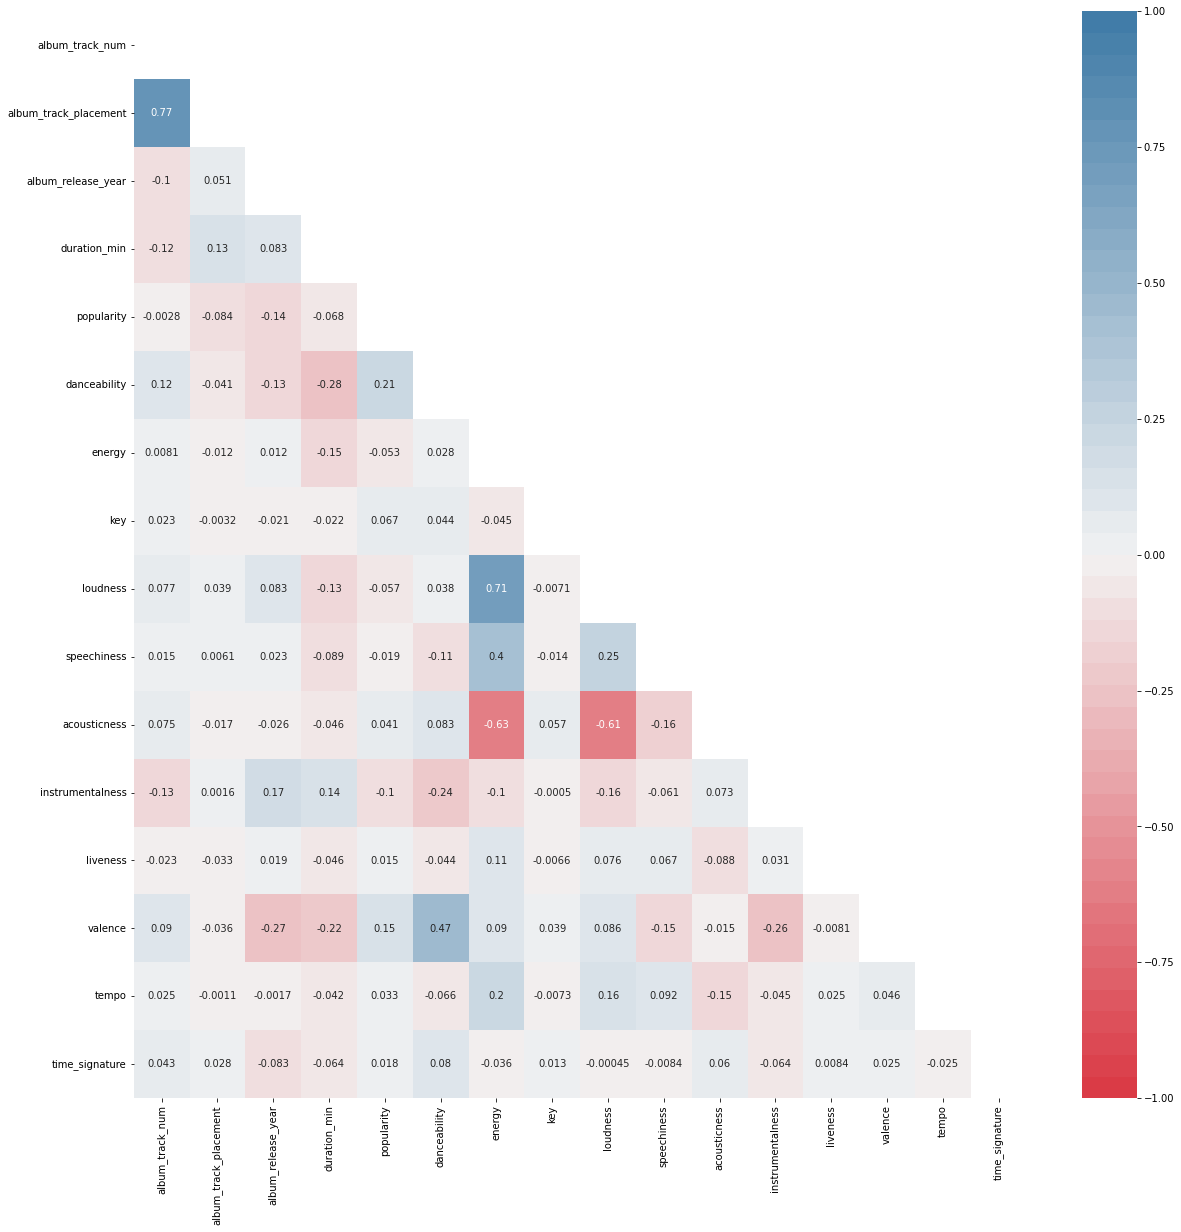

In [18]:
corr = df[numerical].corr()
mask = np.triu(corr)
cmap = sns.diverging_palette(10, 240, n=50)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask, cmap=cmap)

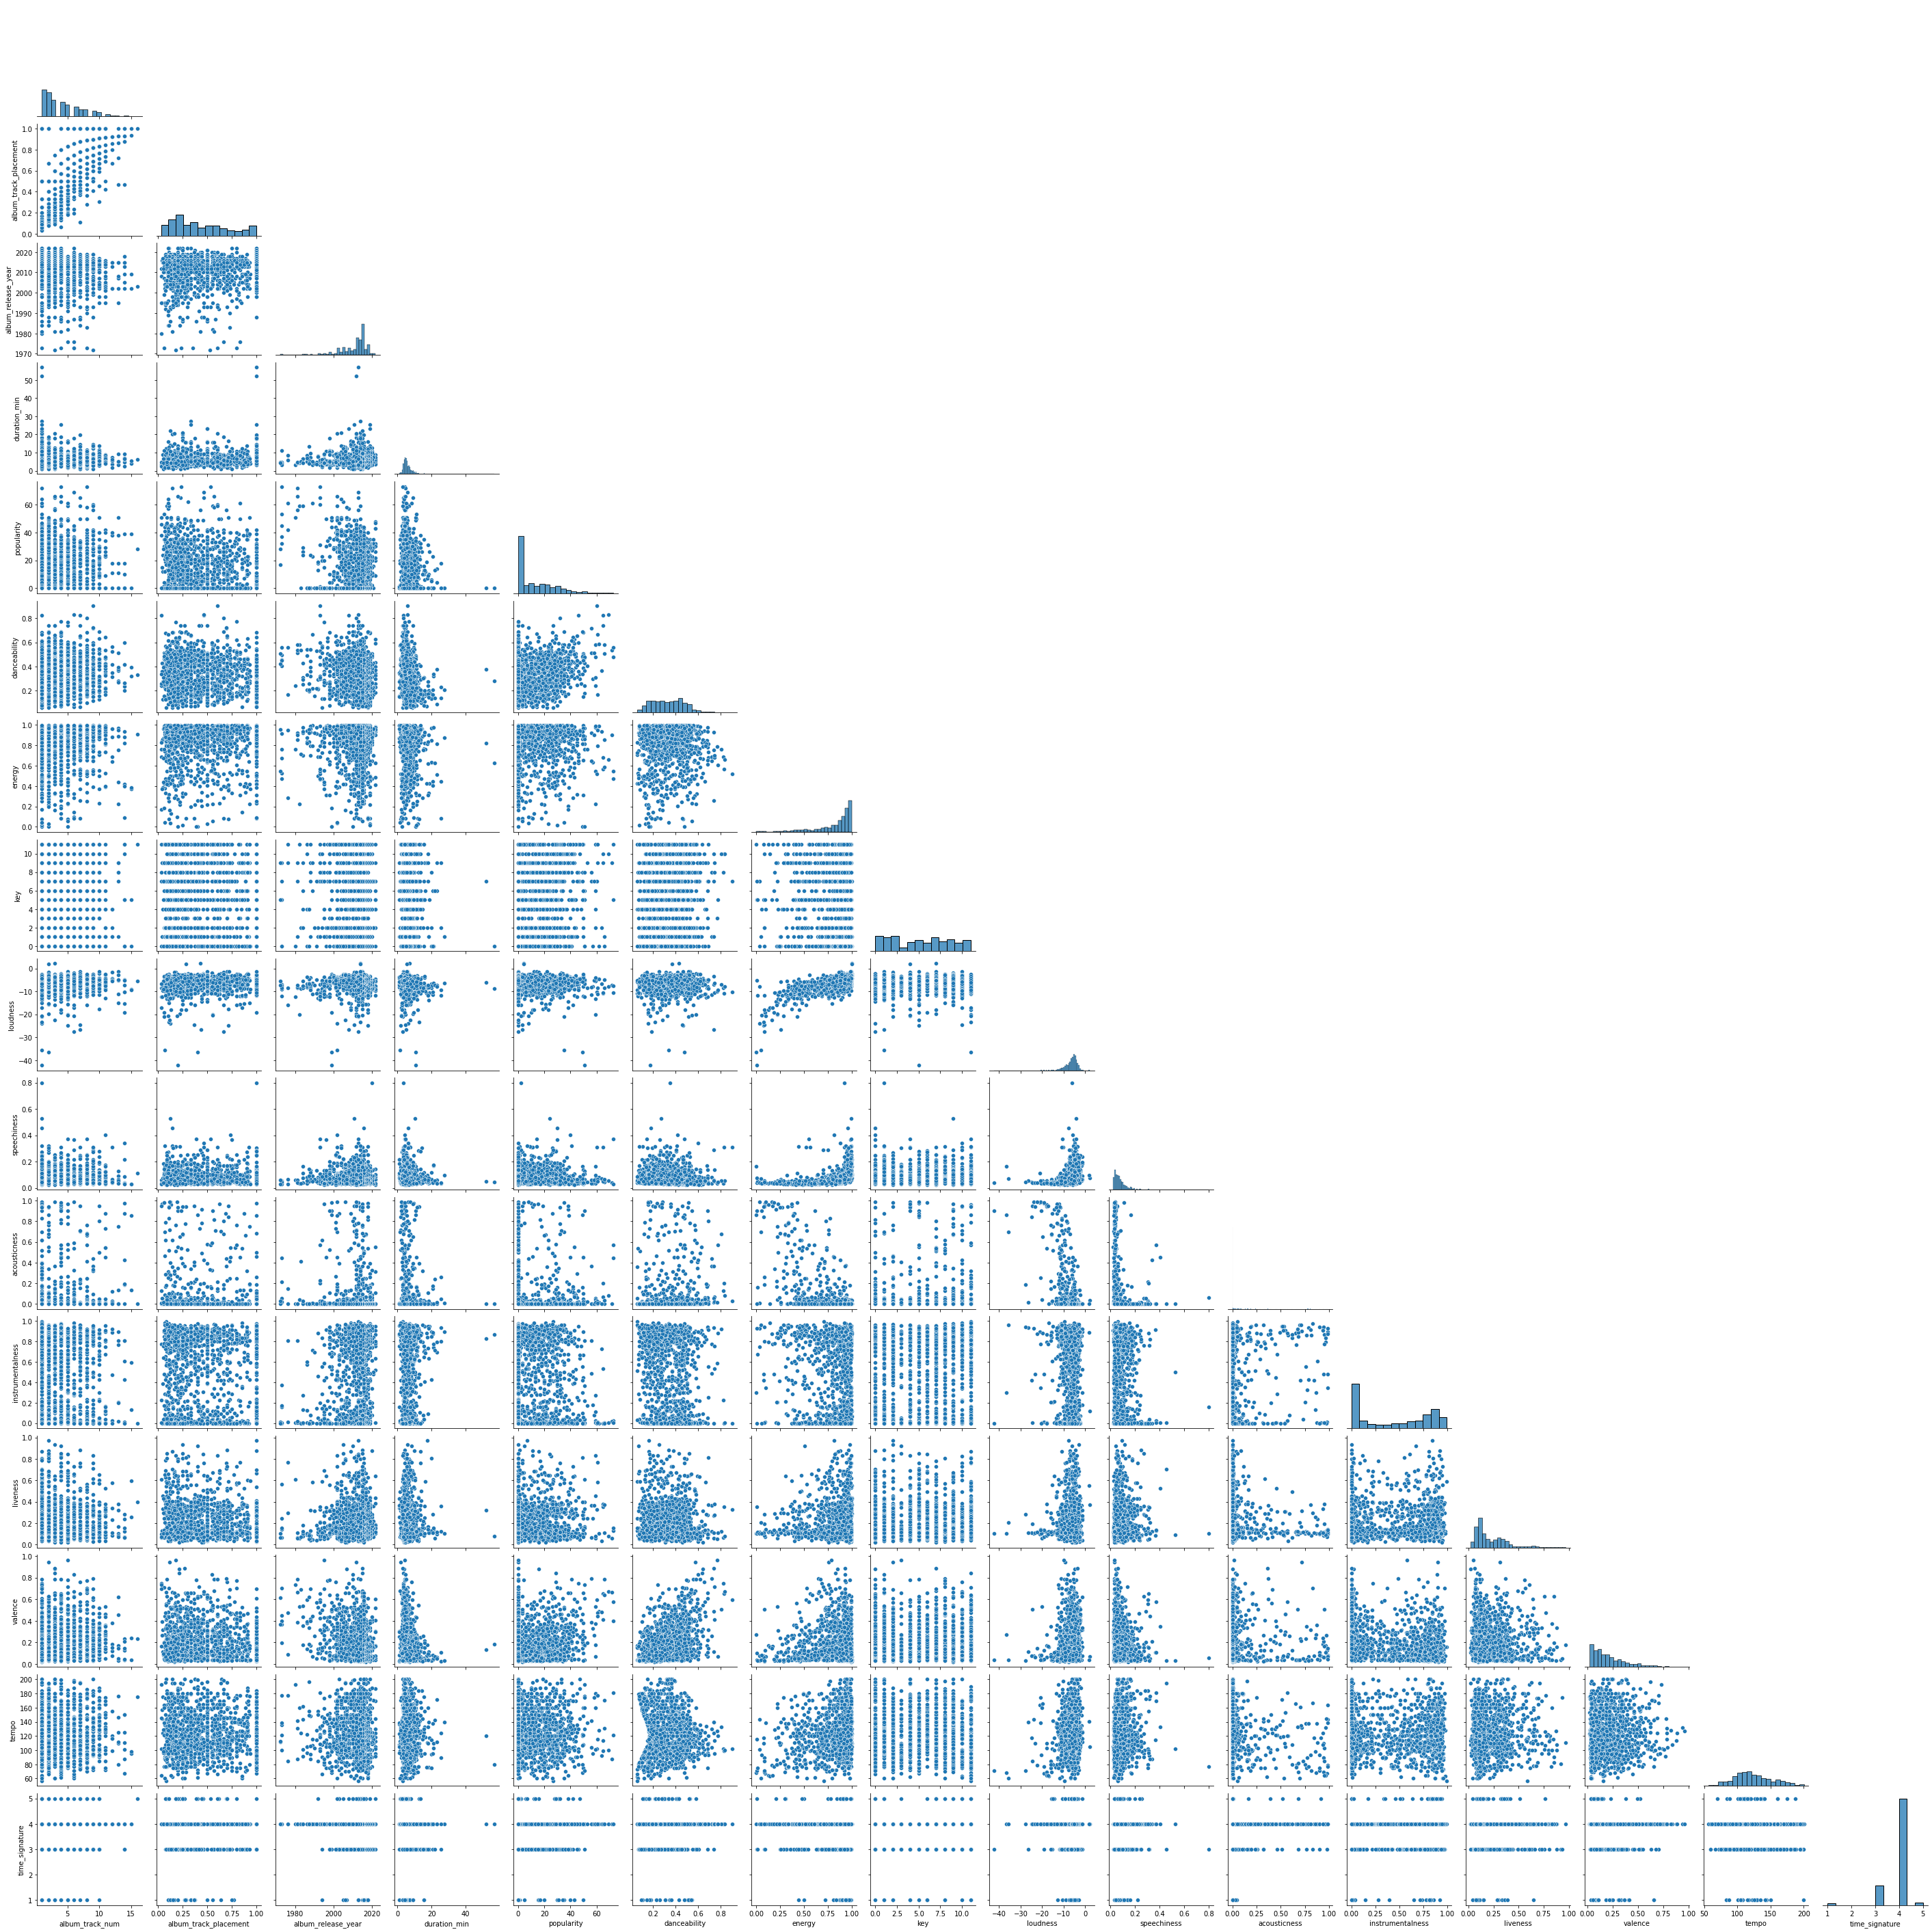

In [19]:
sns.pairplot(df[numerical], corner=True)

# Clustering
I want to see if I can cluster the data. I use K-Means clustering on the numerical features to achieve this. For some fixed number of clusters k, k-means begins by picking random points to be cluster centers, then assigning each point to the cluster with the nearest center. The centers of each cluster are computed, then points are reassigned to the cluster with the nearest center. This process of computing cluster centers and reassigning points repeats until some convergence condition is met, like the sum of squared distances within clusters falling below some level. 

For k-means, means and variances must be standardized. I use mean = 0 and std = 1.

K-means is unsupervised, meaning it does not use labeled data to train. This means that we cannot compare predictions to known values to choose the number of clusters k. Instead, I use the elbow method. For the elbow method, first you choose some range of k values to try. You run k-means for each and plot the sum of squared distances within clusters against the k values. Ideally, the plot should have what looks like an "elbow." For values of k larger than the value at the elbow, the sum of squard distances should decrease much more slowly than it increases for smaller values.

In [29]:
numerical

['album_track_num',
 'album_track_placement',
 'album_release_year',
 'duration_min',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [96]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df[numerical])

100%|██████████| 19/19 [00:26<00:00,  1.41s/it]


TypeError: 'numpy.ndarray' object is not callable

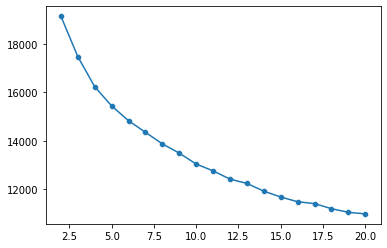

In [91]:
from sklearn.cluster import SpectralClustering
k_range = np.linspace(2, 20, num=19, dtype=int)
ssd = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)

sns.scatterplot(x=k_range, y=ssd)
sns.lineplot(x=k_range, y=ssd)
plt.xticks(list(k_range))
plt.show()

In [108]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_scaled)
cluster_labels = kmeans.labels_

In [109]:
pca = PCA()
pca_vals = pca.fit_transform(df_scaled)

In [110]:
pca_vals.shape, df_scaled.shape

((1336, 16), (1336, 16))

<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

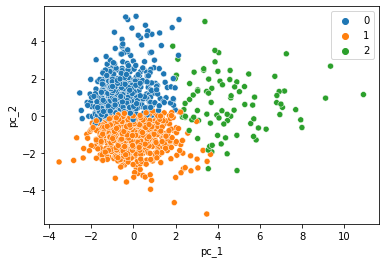

In [111]:
df_pca = pd.DataFrame(pca_vals, columns=[f'pc_{i+1}' for i in range(len(numerical))])
sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=cluster_labels, palette='tab10')

In [113]:
df['cluster_labels'] = cluster_labels +1

In [119]:
df[numerical + ['cluster_labels']].groupby('cluster_labels').agg(['mean', 'std'])

album_track_num           album_track_placement            \
                          mean       std                  mean       std   
cluster_labels                                                             
1                     5.250417  3.089100              0.478413  0.277621   
2                     3.098918  2.253195              0.394010  0.269467   
3                     4.466667  3.709084              0.424691  0.305772   

               album_release_year           duration_min           popularity  \
                             mean       std         mean       std       mean   
cluster_labels                                                                  
1                     2008.454090  8.867143     5.157308  1.753514  16.212020   
2                     2013.063369  5.100598     7.182906  4.503354  10.415765   
3                     2010.955556  7.974554     5.880207  3.708570  14.200000   

                           ... instrumentalness            liveness            \
                      std  ...             mean       std      mean       std   
cluster_labels             ...                                                  
1               17.651498  ...         0.217027  0.305752  0.212398  0.157286   
2               11.253149  ...         0.610877  0.321401  0.241532  0.179507   
3               15.989603  ...         0.633949  0.341724  0.160417  0.099866   

                 valence                 tempo            time_signature  \
                    mean       std        mean        std           mean   
cluster_labels                                                             
1               0.311670  0.177097  125.216169  27.930005       3.899833   
2               0.126774  0.086731  124.878526  29.497328       3.721793   
3               0.147951  0.160926  106.018122  30.952821       3.922222   

                          
                     std  
cluster_labels            
1               0.447942  
2               0.614483  
3               0.403016  

[3 rows x 32 columns]